# TO-DO

- [priority] Confirm if capital accumulation formula is correct.
- include random factors
- include `plot` function in the class.
- convert lists to numpy arrays.


In [1]:
import math

from typing import Union

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# OLG with (Impure) Altruism

(From Acemolgu: Introduction to Modern Economic Growth) 

Each individual lives for two periods, childhood and adulthood. In the second period of his life,
each individual begets an offspring, works, and then his life comes to an end. For simplicity, let
us assume that there is no consumption in childhood (or that it is incorporated in the parent’s
consumption). There are no new households, so population is constant at 1. Each individual
supplies 1 unit of labor inelastically during his adulthood.

Assume individual (i, t) maximies a preference defined as
$$ \log{c_i(t)} + \beta_i \log{b_i(t)}$$ 

subject to 
$$ c_i(t) + b_i(t) \le w(t) + r(t)b_i(t-1) $$

where 

$$ w(t) = f(k(t)) - k(t) f`(k(t)) $$
$$ r(t) = f`(k(t)) $$

and the capital stock is 
$$ k(t+1) = \int_i b_i(t) di



## Code

Example Usage:

```python
olg = OLG(starting_bequests = [10, 30], beta = [0.5, 0.7])

olg.simulate(10)
print(olg.wage)  # Prints wage rate series
olg.plot() 
```


In [10]:
class OLG:
    def __init__(self, 
        beta: Union[int, list] = 0.5,
        starting_bequests: Union[int, list] = 1,
        alpha: float = 0.8,
        A: float = 1
    ):
        """OLG with impure altruism model. 

        n households can be specified, each with it's own bequest factor (beta) and initial bequest value (b_i at time t). 
        
        Per capita production function defined as f(k) = Ak^alpha.

        Parameters
        ----------
        beta : int | list, optional
            Bequest factor, by default 0.5. Can be a list form multiple households.
        starting_bequests : int | list, optional
            Initial bequests for each household, by default 1. Can be a list form multiple households.
        alpha : float, optional
            alpha in production function, by default 0.8
        A : float, optional
            A in production function, by default 1
        """
        
        # Convert bequests and beta to arrays if not arrays yet.
        if type(starting_bequests) in (list, np.array, pd.Series):
            if type(beta) in (int, float):
                beta = [beta]*len(starting_bequests)
            else:
                assert len(starting_bequests) == len(beta), "starting_bequests and beta length not equal."
            self.household_count = len(starting_bequests) 
        elif type(beta) in (list, np.array, pd.Series):
            self.household_count = len(beta) 
            starting_bequests =  [starting_bequests] * self.household_count
        else:
            beta, starting_bequests = [beta], [starting_bequests]

        bequests = np.array(starting_bequests).reshape(self.household_count, 1)  # Each element in bequests is the series of bequests over time for household i.

        self.beta = beta
        self.bequests = bequests
        self.wage = [-1]
        self.A = A
        self.alpha = alpha


    def per_capita_production_function(self, k_t) -> float:
        return self.A * k_t**self.alpha

    def diff_per_capita_production_function(self, k_t) -> float:
        return self.A * self.alpha * k_t**(self.alpha - 1)
    
    def steady_state_k_t(self):
        return None 

    def household_utility(self, X: list, beta) -> float:
        c, b = X[0], X[1]
        if not all([c, b]):
            return np.inf
        return -1 * (np.log(c) + beta * np.log(b))
    

    def _budget_constraint(self, X, w_t, r_t, b_t_minus_1) -> float:
        c_t, b_t = X[0], X[1]
        return c_t + b_t - w_t - r_t * b_t_minus_1
    
    def _get_household_decision(self, w_t, r_t, b_t_minus_1, beta) -> tuple:
        """Uses scipy.optimize to solve for optimal consumption and savings."""
        y_t = w_t + r_t * b_t_minus_1
        initial_guess = [y_t / 2, y_t / 2]
        bounds = [(0, y_t), (0, y_t)]

        constraints = [{'type': 'eq',
                        'fun': self._budget_constraint, 
                        'args': (w_t, r_t, b_t_minus_1)
                       }]
        
        # Solve optimization problem
        result = minimize(self.household_utility, 
                          initial_guess, 
                          constraints=constraints, 
                          bounds=bounds, 
                          args=(beta),
                          method='SLSQP')
        return result.x 
    

    def simulate(self, t):
        for _ in range(t):
            k_t = sum([i[-1] for i in self.bequests])
            r_t = self.diff_per_capita_production_function(k_t)
            w_t = self.per_capita_production_function(k_t) - k_t * r_t

            new_bequests = np.zeros((self.household_count, 1))

            for i in range(self.household_count):
                b_t_minus_1 = self.bequests[i, -1]
                beta = self.beta[i]
                household_decision = self._get_household_decision(w_t, r_t, b_t_minus_1, beta)
                c_t, b_t = household_decision[0], household_decision[1]

                new_bequests[i, 0] = b_t
            
            self.bequests = np.column_stack((self.bequests, new_bequests))
            self.wage.append(w_t)

    def plot(self, cumulative: bool = False, figsize=(11,7)):
        plt.figure(figsize=figsize)

        if cumulative:
            data = np.cumsum(self.bequests, axis=1)
            plt.title("Cumulative Bequests (Wealth) over Time")
        else:
            data = self.bequests
            plt.title("Bequests over Time")

        for i in range(data.shape[0]):
            plt.plot(data[i], label=r"$\beta$" + f"={self.beta[i]}"+f", starting bequest={self.bequests[i,0]}")


        plt.legend()
        plt.show()

In [13]:
olg = OLG(beta=[0.75, 0.5, 0.25], starting_bequests=[0.1, 0.3, 0.5], A=1.5)

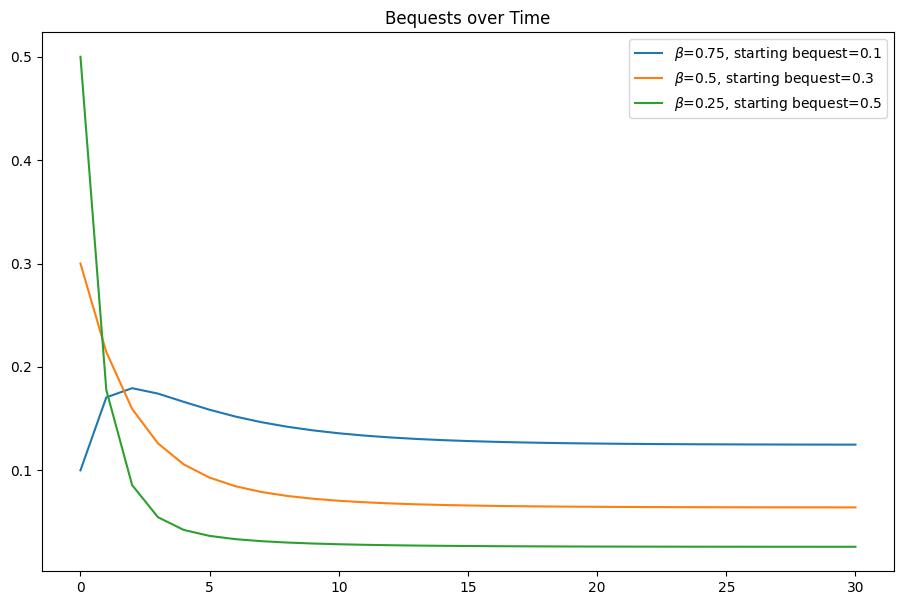

In [14]:
olg.simulate(30)
olg.plot(cumulative=False)